In [1]:
import numpy as np

In [3]:
class GaussianNaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        n_samples, n_features = X.shape
        n_classes = len(self.classes)

        self.priors = np.zeros(n_classes)
        self.means = np.zeros((n_classes, n_features))
        self.stds = np.zeros((n_classes, n_features))

        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.priors[idx] = X_c.shape[0] / n_samples
            self.means[idx] = X_c.mean(axis=0)
            self.stds[idx] = X_c.std(axis=0) + 1e-9  # защита от деления на 0

    def _gaussian_pdf(self, x, mean, std):
        return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(
            -0.5 * ((x - mean) / std) ** 2
        )

    def predict(self, X):
        predictions = []

        for x in X:
            posteriors = []

            for idx, c in enumerate(self.classes):
                prior = np.log(self.priors[idx])

                likelihood = np.sum(
                    np.log(self._gaussian_pdf(x, self.means[idx], self.stds[idx]))
                )

                posterior = prior + likelihood
                posteriors.append(posterior)

            predictions.append(self.classes[np.argmax(posteriors)])

        return np.array(predictions)


# Comparison our model and model from sklearn

In [4]:
from sklearn.datasets import make_blobs

X, y = make_blobs(
    n_samples=300,
    centers=2,
    n_features=2,
    cluster_std=1.5,
    random_state=42
)


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)
GNB= GaussianNB()
my_model = GaussianNaiveBayes()
GNB.fit(X_train,y_train)
my_model.fit(X_train,y_train)
y_pred_nb = GNB.predict(X_test)
y_pred_my_model = my_model.predict(X_test)

In [7]:
acc_sklearn = np.mean(y_pred_nb == y_test)
acc_my = np.mean(y_pred_my_model == y_test)

print("Sklearn GaussianNB accuracy:", acc_sklearn)
print("My GaussianNaiveBayes accuracy:", acc_my)


Sklearn GaussianNB accuracy: 1.0
My GaussianNaiveBayes accuracy: 1.0


In [8]:
from sklearn.metrics import confusion_matrix

print("Sklearn:")
print(confusion_matrix(y_test, y_pred_nb))

print("\nMy model:")
print(confusion_matrix(y_test, y_pred_my_model))


Sklearn:
[[42  0]
 [ 0 48]]

My model:
[[42  0]
 [ 0 48]]


On simple synthetic data, the results of my implementation completely match sklearn.
This confirms the correctness of the algorithm implementation.
Differences can only appear on large or complex data due to numerical instability and assumptions about the independence of features.

# Lets check our models with classes overlap 

In [9]:
import numpy as np

np.random.seed(42)
n_samples = 100

X0 = np.random.normal(0, 1.5, size=(n_samples, 2))
X1 = np.random.normal(1, 1.5, size=(n_samples, 2))

X = np.vstack([X0, X1])
y = np.array([0]*n_samples + [1]*n_samples)


In [10]:
X[:,1] = X[:,0] + np.random.normal(0, 0.3, size=(2*n_samples,))


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
my_model = GaussianNaiveBayes()
my_model.fit(X_train, y_train)
y_pred_my = my_model.predict(X_test)

from sklearn.naive_bayes import GaussianNB
sk_model = GaussianNB()
sk_model.fit(X_train, y_train)
y_pred_sk = sk_model.predict(X_test)
acc_my = np.mean(y_pred_my == y_test)
acc_sk = np.mean(y_pred_sk == y_test)

print("My NB accuracy:", acc_my)
print("Sklearn NB accuracy:", acc_sk)


My NB accuracy: 0.7333333333333333
Sklearn NB accuracy: 0.7333333333333333


Accuracy decreased compared to last experiment because classes overlap a lot — NB starts making mistakes on the border 

# How gonna work our models with noisy data?

In [14]:
import numpy as np

np.random.seed(42)
n_samples = 50  
d = 2         

X0 = np.random.normal(0, 1, size=(n_samples, d))
X1 = np.random.normal(1, 1, size=(n_samples, d))

noise = np.random.normal(0, 0.5, size=(2*n_samples, d))
X = np.vstack([X0, X1]) + noise
y = np.array([0]*n_samples + [1]*n_samples)


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [16]:
my_model = GaussianNaiveBayes()
my_model.fit(X_train, y_train)
y_pred_my = my_model.predict(X_test)

from sklearn.naive_bayes import GaussianNB
sk_model = GaussianNB()
sk_model.fit(X_train, y_train)
y_pred_sk = sk_model.predict(X_test)


In [17]:
acc_my = np.mean(y_pred_my == y_test)
acc_sk = np.mean(y_pred_sk == y_test)

print("My NB accuracy:", acc_my)
print("Sklearn NB accuracy:", acc_sk)


My NB accuracy: 0.7
Sklearn NB accuracy: 0.7


In a small and noisy sample, the accuracy of Naive Bayes decreases, and errors are concentrated in "noisy" areas.
As the sample size increases, the model stabilizes, and the difference with sklearn decreases.
The experiment shows the sensitivity of NB to noise and data size.

# 2D graph with decision boundaries

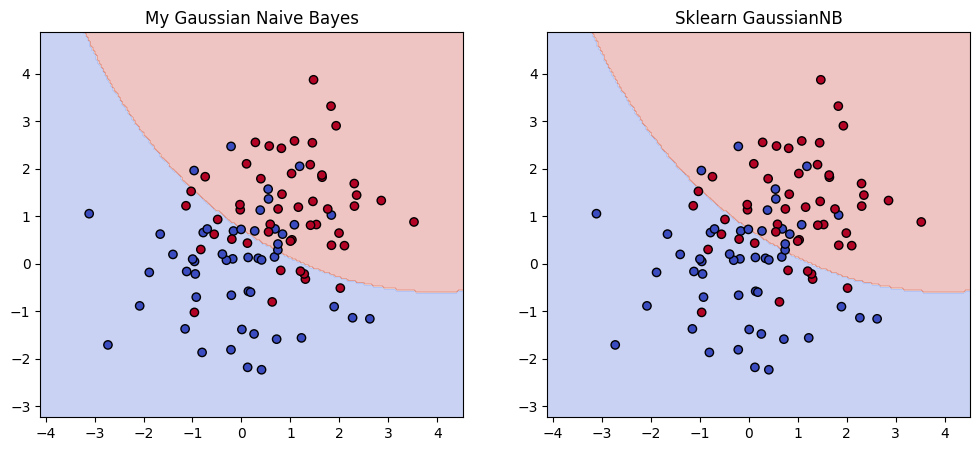

In [18]:
import matplotlib.pyplot as plt

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)

grid = np.c_[xx.ravel(), yy.ravel()]
Z_my = my_model.predict(grid)
Z_sk = sk_model.predict(grid)

Z_my = Z_my.reshape(xx.shape)
Z_sk = Z_sk.reshape(xx.shape)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].contourf(xx, yy, Z_my, alpha=0.3, cmap=plt.cm.coolwarm)
axes[0].scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.coolwarm)
axes[0].set_title("My Gaussian Naive Bayes")

axes[1].contourf(xx, yy, Z_sk, alpha=0.3, cmap=plt.cm.coolwarm)
axes[1].scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.coolwarm)
axes[1].set_title("Sklearn GaussianNB")

plt.show()
